In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

In [41]:
from zipline.api import order, record, symbol, order_target_percent, set_slippage,set_benchmark,slippage
import zipline
import matplotlib.pyplot as plt
from datetime import datetime
import math as m
from talib import EMA

In [72]:
def initialize(context):
      set_benchmark(symbol("BTC"))
      context.asset = symbol('BTC')
      # Constant fitted separately depends on windows used
      context.const = 1.0
      set_slippage(slippage.FixedBasisPointsSlippage(basis_points=25, volume_limit=1))

def handle_data(context, data):
      #EMWA average slow moving average, adjusted by vol 
      current_positions = context.portfolio.positions[symbol('BTC')].amount
      starting_cash = context.portfolio.starting_cash
      cash = context.portfolio.cash
      value = context.portfolio.portfolio_value
      current_pnl = context.portfolio.pnl
      trailing_window = data.history(symbol("BTC"), 'open', 360, '1d')
      if trailing_window.isnull().values.any():
          return
      short_ema = EMA(trailing_window.values, timeperiod=short)
      long_ema = EMA(trailing_window.values, timeperiod=long)
      emavevt = short_ema - long_ema
      emdf = pd.DataFrame(emavevt)
      emdf.fillna(0)
      average_ema = emdf.mean()
      std_ema = emdf.std()
      emafac = (short_ema[-1] - long_ema[-1] - average_ema) / std_ema
      Pct_to_invest = max(min(float(emafac) / context.const, 1), 0)
      #Invest_target = Pct_to_invest * value
      #order_amount = Invest_target - current_positions  
      #Holding_target =total_value/value
      #order_amount = Holding_target - current_positions
      order_target_percent(context.asset, Pct_to_invest)
      #if ( order_amount < 0):
      #    buy = False 
      #    sell = True
      #elif ( order_amount > 0):
      #    buy = True
      #    sell = False
      #else:
      #    buy = False
      #    sell = False
      new_position = context.portfolio.positions[symbol('BTC')].amount
      #
      record(BTC=data.current(symbol('BTC'), 'price'),
           short_ema=short_ema[-1],
           long_ema=long_ema[-1],
           average=average_ema,
           stddev=std_ema,
           emafac=emafac,
           target = Pct_to_invest,
           current = current_positions,
           position = new_position,
           start = starting_cash,
           cash = cash,
           value = value)
           #buy=buy,
           #sell=sell)  

In [5]:
def analyze(context, perf):
    
    perf['max'] = perf.portfolio_value.cummax()
    perf['dd'] = (perf.portfolio_value / perf['max']) - 1
    maxdd = perf['dd'].min()
    
    ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1
    
    print("Annualized Return: {:.2%} Max Drawdown: {:.2%}".format(ann_ret, maxdd))

    return

In [6]:
#GDAX bitcoin exchange data
import cbpro
import dateutil.parser as dp

def getDateTimeFromISO8601String(s):
    d = dateutil.parser.parse(s)
    return d

In [22]:
from datetime import datetime
from datetime import timedelta
ts = int("1437350400")

# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case
start_date = datetime.utcfromtimestamp(ts)
end_date = start_date + pd.DateOffset(days=300)


In [23]:
a_tot=[]
a=[]
client = cbpro.PublicClient()
a_tot = client.get_product_historic_rates('BTC-USD',granularity=86400, start=start_date ,end=end_date)
b = pd.DataFrame(a_tot)
b.columns = [ 'time', 'low', 'high', 'open', 'close', 'volume' ]


for i in range(1,10):
   start_date = end_date +  pd.DateOffset(days=1)
   end_date = start_date + pd.DateOffset(days=300)
   if (start_date > datetime.today()):
     break
   a = client.get_product_historic_rates('BTC-USD',granularity=86400, start=start_date ,end=end_date)
   b2 = pd.DataFrame(a)
   b2.columns = [ 'time', 'low', 'high', 'open', 'close', 'volume' ]
   frames = [b2, b]
   result = pd.concat(frames)
   b =result


In [24]:
result['time'] = result['time'].apply(datetime.utcfromtimestamp)

In [25]:
result.rename(columns={'time':'date'},inplace=True)


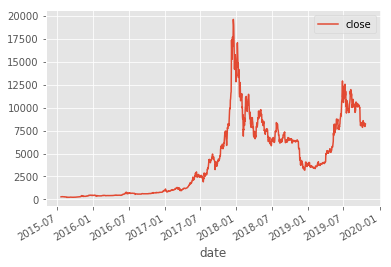

In [26]:
#Plot out the entire history

from matplotlib import style
resultstoplot = [result['date'],result['close']]
style.use("ggplot")
result.plot(x='date', y='close')
plt.show()

In [27]:
#Backfill data

In [28]:
result.sort_values(by=['date'], inplace=True,ascending=True)

In [29]:
data = OrderedDict()
tickers = ["BTC"]
result.set_index('date', inplace=True) 

In [30]:
result2 = result.resample('1D').bfill()

In [31]:

for ticker in tickers:
    data[ticker] = result2
    print(data[ticker].head())


panel = pd.Panel(data)
panel_minor_axis = ["low","high","open","close","volume"]
panel_major_axis = panel.major_axis.tz_localize(pytz.utc)

print(panel)

               low    high    open   close       volume
date                                                   
2015-07-21  276.85  281.27  279.96  277.32  4943.559434
2015-07-22  275.01  278.54  277.33  277.89  4687.909383
2015-07-23  276.28  279.75  277.96  277.39  5306.919575
2015-07-24  276.43  291.52  277.23  289.12  7362.469083
2015-07-25  286.82  291.67  289.12  289.70  4102.452960
<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 1554 (major_axis) x 5 (minor_axis)
Items axis: BTC to BTC
Major_axis axis: 2015-07-21 00:00:00 to 2019-10-21 00:00:00
Minor_axis axis: low to volume


In [32]:
import trading_calendars
from trading_calendars.always_open import AlwaysOpenCalendar

In [33]:
data = [['(2,8)', 2, 8], ['(4,16)', 4, 16], ['(8,32)', 8, 32],['(16,64)', 16, 64],['(32,128)', 32, 128],['(64,256)', 64, 256]]
df = pd.DataFrame(data, columns = ['Name', 'ShortWindow','LongWindow'])
n = df.shape
a = range(0,n[0])
df.iloc[1,1]
for n in a:
   print(df.iloc[n,1],df.iloc[n,2])

2 8
4 16
8 32
16 64
32 128
64 256


In [73]:
#approx 1y window
#This is a bad one, use one that has some downturns
OverallCapital = 100000
results =[]
for n in a:  
    short = df.iloc[n,1]
    long = df.iloc[n,2]
    perf = zipline.run_algorithm(start=datetime(2018, 1, 1, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2019, 1, 1, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              trading_calendar=AlwaysOpenCalendar(),
                              capital_base=OverallCapital,
                              handle_data=handle_data,
                              data=panel)
    results.append(perf)

/home/christopher/.local/lib/python3.5/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/christopher/.local/lib/python3.5/site-packages/empyrical/stats.py:711: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/home/christopher/.local/lib/python3.5/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/christopher/.local/lib/python3.5/site-packages/empyrical/stats.py:711: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/home/christopher/.local/lib/python3.5/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/christopher/.local/lib/python3.5/site-packages/empyrical/stats.py:711: RuntimeWarning: inval

In [74]:
len(results)
list(results[0])

['BTC',
 'algo_volatility',
 'algorithm_period_return',
 'alpha',
 'average',
 'benchmark_period_return',
 'benchmark_volatility',
 'beta',
 'capital_used',
 'cash',
 'current',
 'emafac',
 'ending_cash',
 'ending_exposure',
 'ending_value',
 'excess_return',
 'gross_leverage',
 'long_ema',
 'long_exposure',
 'long_value',
 'longs_count',
 'max_drawdown',
 'max_leverage',
 'net_leverage',
 'orders',
 'period_close',
 'period_label',
 'period_open',
 'pnl',
 'portfolio_value',
 'position',
 'positions',
 'returns',
 'sharpe',
 'short_ema',
 'short_exposure',
 'short_value',
 'shorts_count',
 'sortino',
 'start',
 'starting_cash',
 'starting_exposure',
 'starting_value',
 'stddev',
 'target',
 'trading_days',
 'transactions',
 'treasury_period_return',
 'value']

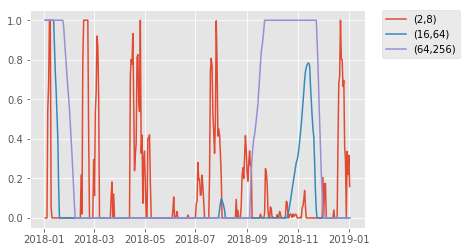

In [75]:
#plot the cumulative returns
from matplotlib import style
style.use("ggplot")
fast = plt.plot(results[0].target,label = df.iloc[0,0])
med  = plt.plot(results[3].target,label = df.iloc[3,0])
slow = plt.plot(results[5].target,label = df.iloc[5,0])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0)

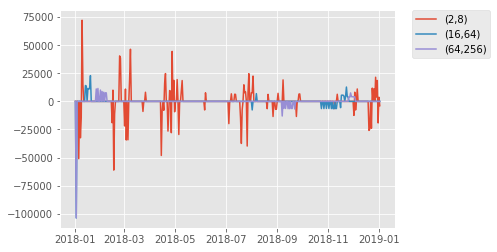

In [76]:
fast = plt.plot(results[0].capital_used,label = df.iloc[0,0])
med  = plt.plot(results[3].capital_used,label = df.iloc[3,0])
slow = plt.plot(results[5].capital_used,label = df.iloc[5,0])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0)

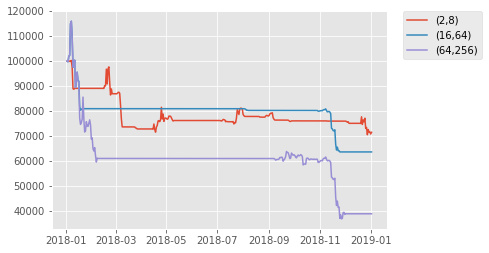

In [77]:
fast = plt.plot(results[0].value,label = df.iloc[0,0])
med  = plt.plot(results[3].value,label = df.iloc[3,0])
slow = plt.plot(results[5].value,label = df.iloc[5,0])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0)

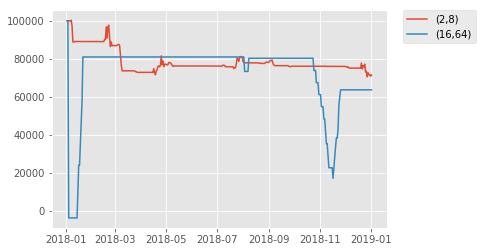

In [78]:
fast = plt.plot(results[0].value,label = df.iloc[0,0])
med  = plt.plot(results[3].starting_cash,label = df.iloc[3,0])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0)

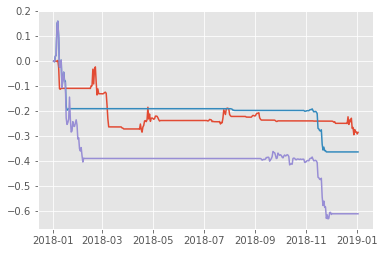

In [79]:
cum1 = results[0].value.pct_change().fillna(0).add(1).cumprod().sub(1)
cum2 = results[3].value.pct_change().fillna(0).add(1).cumprod().sub(1)
cum3 = results[5].value.pct_change().fillna(0).add(1).cumprod().sub(1)
fast = plt.plot(cum1,label = df.iloc[0,0] )
med  = plt.plot(cum2,label = df.iloc[3,0])
slow = plt.plot(cum3,label = df.iloc[5,0])
#plt.show()

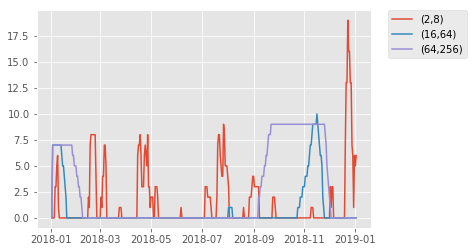

In [80]:
fast = plt.plot(results[0].position,label = df.iloc[0,0])
med  = plt.plot(results[3].position,label = df.iloc[3,0])
slow = plt.plot(results[5].position,label = df.iloc[5,0])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0)

Start date,2018-01-01
End date,2019-01-01
Total months,17
,Backtest
Annual return,-20.6%
Cumulative returns,-28.5%
Annual volatility,21.8%
Sharpe ratio,-0.95
Calmar ratio,-0.70
Stability,0.34
Max drawdown,-29.7%


/home/christopher/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.66,2018-01-06,2018-12-27,NaT,NaN
1,0.13,2018-01-04,2018-01-05,2018-01-06,2
2,0.00,2018-01-01,2018-01-01,2018-01-01,1
3,0.00,2018-01-01,2018-01-01,2018-01-01,1
4,0.00,2018-01-01,2018-01-01,2018-01-01,1


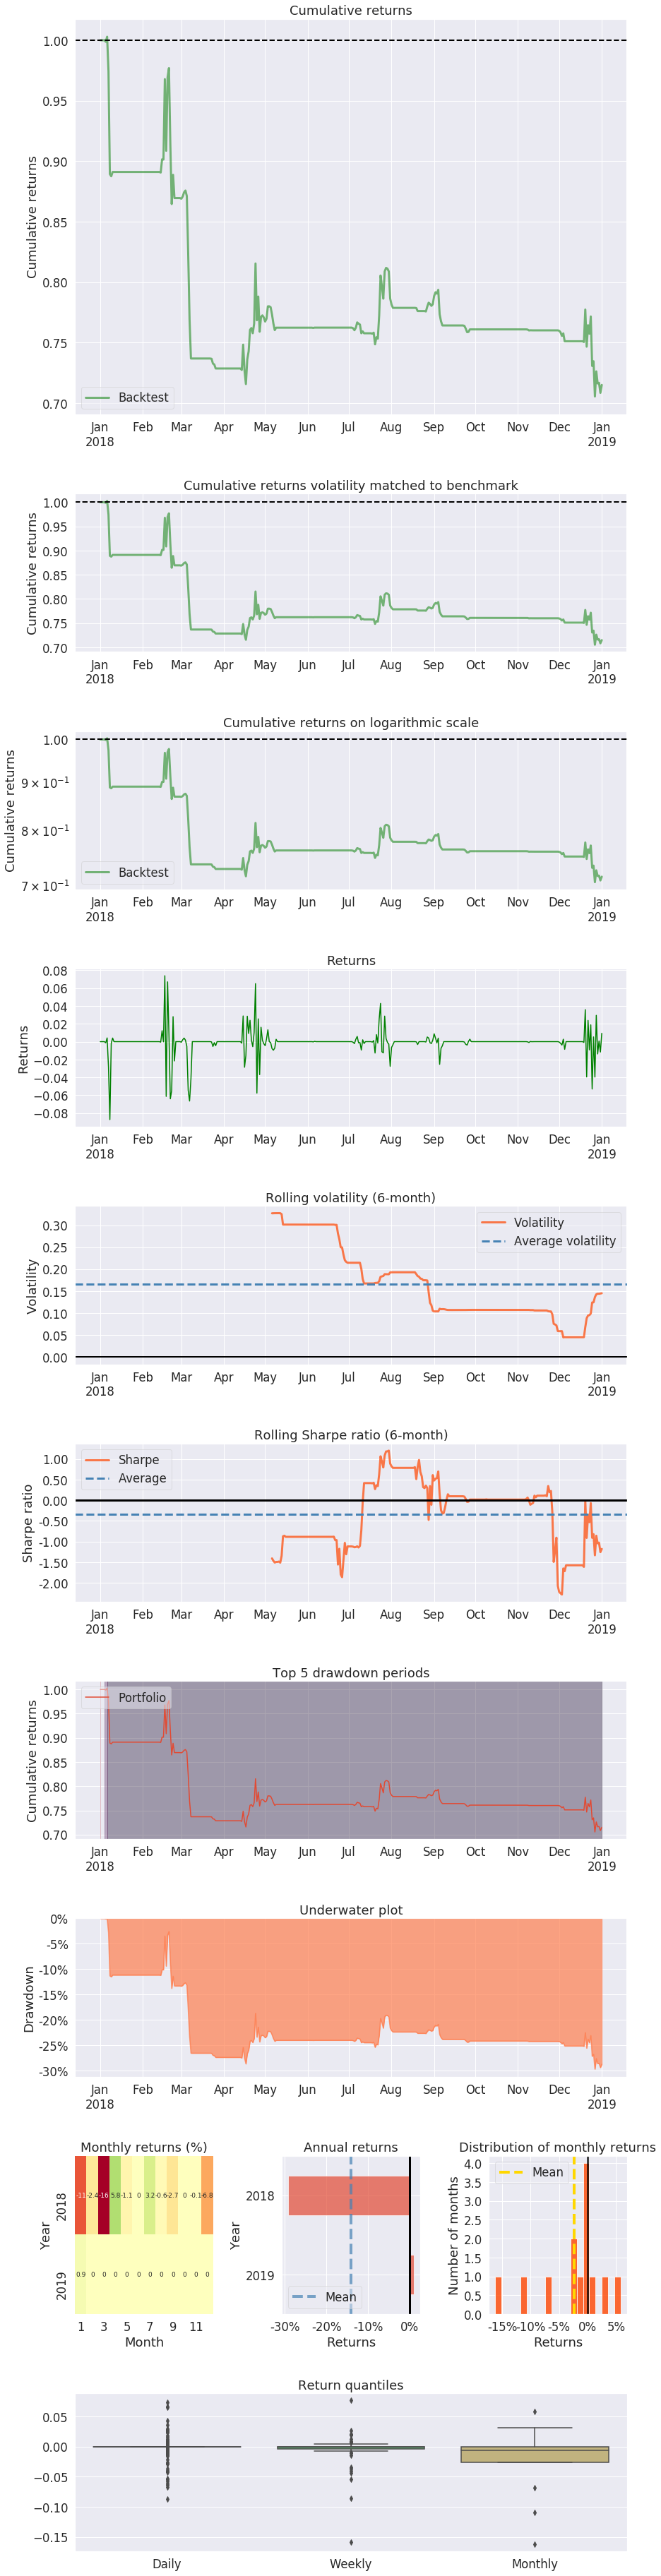

In [81]:
#Analyse the results using pyfolio - very handy
import pyfolio as pf
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results[0])
ts  = pf.create_returns_tear_sheet(returns, benchmark_rets=None)

Start date,2018-01-01
End date,2019-01-01
Total months,17
,Backtest
Annual return,-19.2%
Cumulative returns,-26.6%
Annual volatility,16.5%
Sharpe ratio,-1.21
Calmar ratio,-0.65
Stability,0.58
Max drawdown,-29.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.29,2018-01-06,2018-12-27,NaT,NaN
1,0.00,2018-01-01,2018-01-01,2018-01-01,1
2,0.00,2018-01-01,2018-01-01,2018-01-01,1
3,0.00,2018-01-01,2018-01-01,2018-01-01,1
4,0.00,2018-01-01,2018-01-01,2018-01-01,1


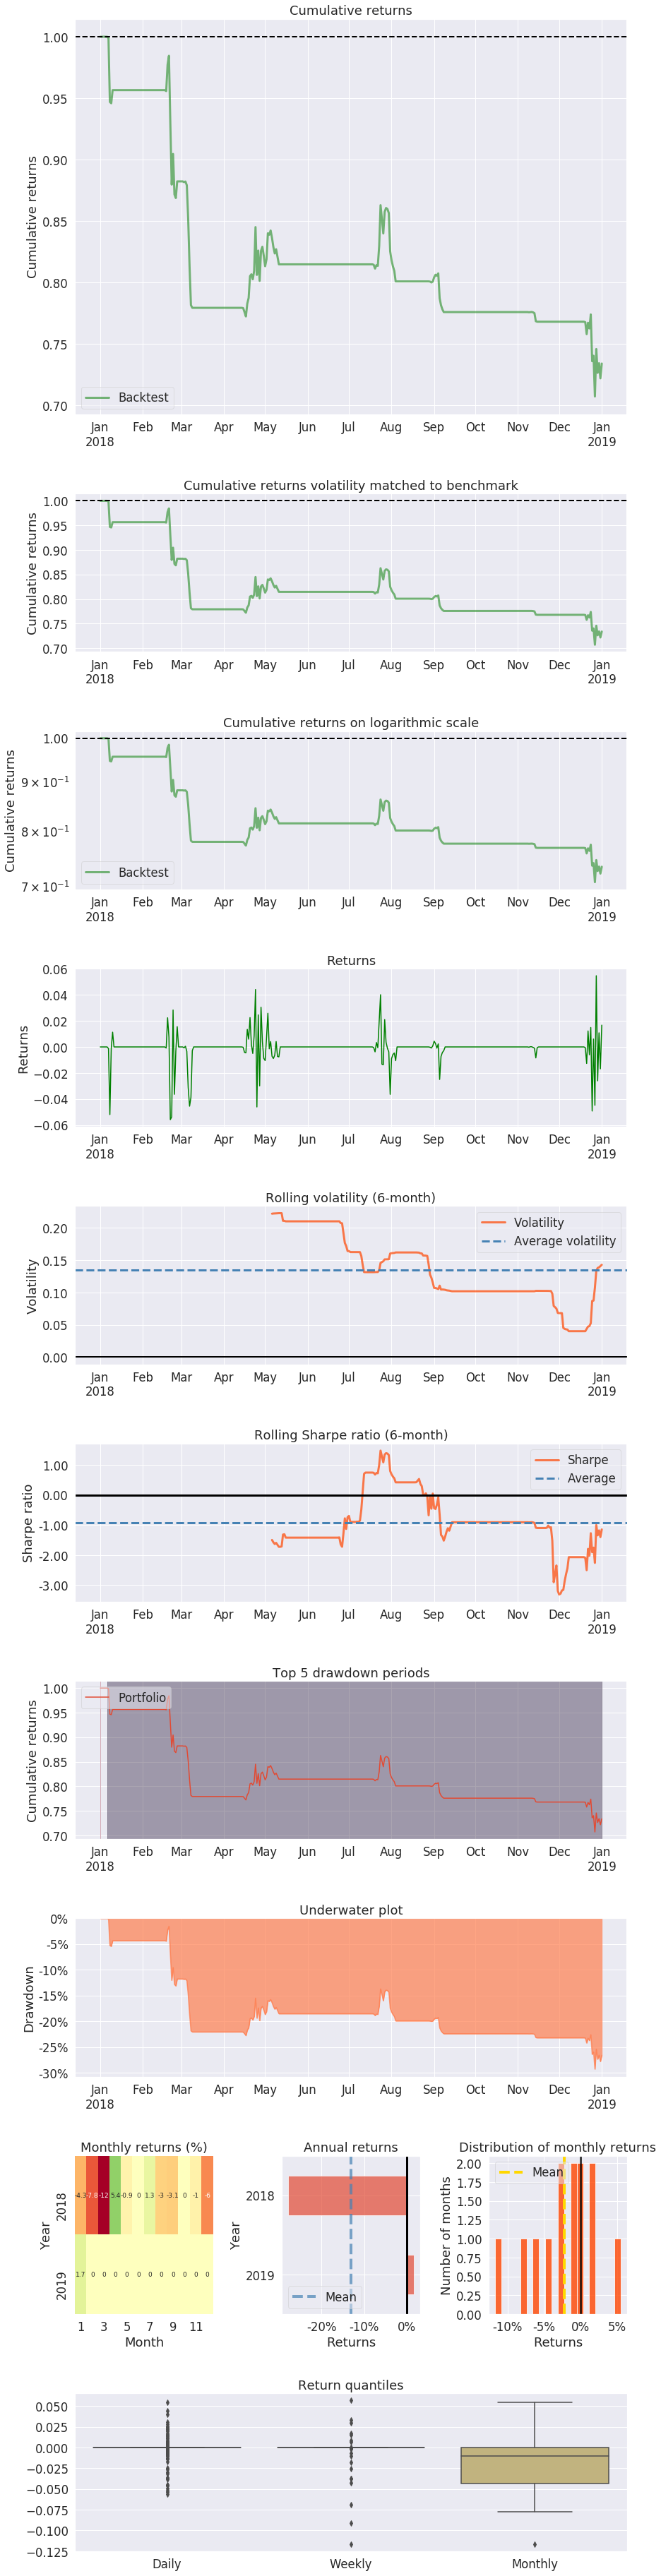

In [82]:
#Analyse the results using pyfolio - very handy
import pyfolio as pf
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results[1])
pf.create_returns_tear_sheet(returns, benchmark_rets=None)

Start date,2018-01-01
End date,2019-01-01
Total months,17
,Backtest
Annual return,-10.0%
Cumulative returns,-14.2%
Annual volatility,6.5%
Sharpe ratio,-1.60
Calmar ratio,-0.64
Stability,0.92
Max drawdown,-15.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.69,2018-01-06,2018-12-27,NaT,NaN
1,0.00,2018-01-01,2018-01-01,2018-01-01,1
2,0.00,2018-01-01,2018-01-01,2018-01-01,1
3,0.00,2018-01-01,2018-01-01,2018-01-01,1
4,0.00,2018-01-01,2018-01-01,2018-01-01,1


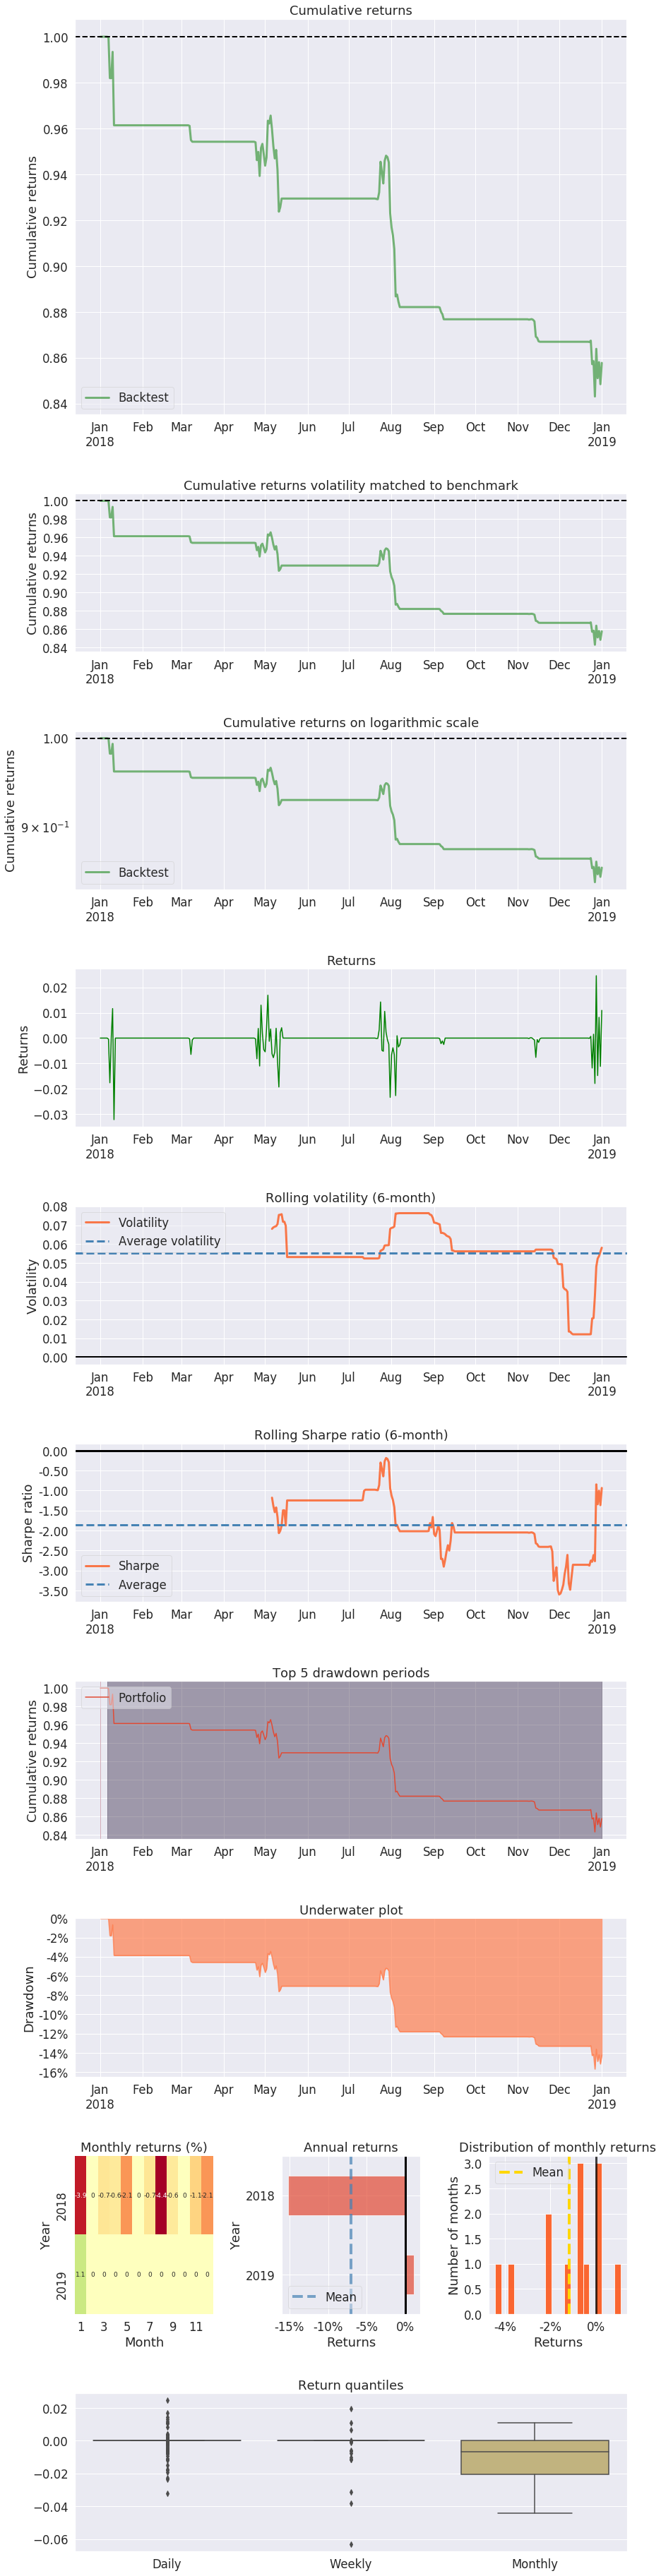

In [83]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results[2])
pf.create_returns_tear_sheet(returns, benchmark_rets=None)

import pyfolio as pf
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results[2])
pf.create_returns_tear_sheet(returns, benchmark_rets=None)

In [84]:
for x in range(0,5):
    av = np.mean(results[x]['sharpe'])
    print(av)

-1.599749591520779
-1.8026665658710415
-1.9705152951858844
-1.014096496133441
-1.270611348308137
